<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/LightGBM(3_Levels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
# LightGBM Classification Model for Agricultural Production Prediction
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")


In [67]:
# Step 1: Load the datasets
print("Step 1: Loading datasets...")
try:
    train_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/train.csv')
    validation_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/validation.csv')
    test_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/test.csv')
    print(f"Train data shape: {train_df.shape}")
    print(f"Validation data shape: {validation_df.shape}")
    print(f"Test data shape: {test_df.shape}")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please make sure train.csv, validation.csv, and test.csv files are in the current directory")
    exit()

Step 1: Loading datasets...
Train data shape: (3942, 84)
Validation data shape: (845, 84)
Test data shape: (845, 84)


In [68]:
# Step 2: Create labels based on quantiles for production column
print("\nStep 2: Creating quantile-based labels...")

def create_quantile_labels(data, column_name='Production (M.Ton)'):
    """Create low, medium, high labels based on quantiles"""
    if column_name not in data.columns:
        print(f"Error: '{column_name}' column not found in data")
        print(f"Available columns: {list(data.columns)}")
        return None

    # Handle any missing values
    production_data = data[column_name].dropna()

    # Calculate quantiles (33rd and 67th percentiles)
    q33 = production_data.quantile(0.33)
    q67 = production_data.quantile(0.67)

    # Create labels
    labels = []
    for value in data[column_name]:
        if pd.isna(value):
            labels.append('medium')  # Default for missing values
        elif value <= q33:
            labels.append('low')
        elif value <= q67:
            labels.append('medium')
        else:
            labels.append('high')

    return labels, q33, q67

# Create labels for all datasets using training data quantiles
train_labels, q33, q67 = create_quantile_labels(train_df, 'Production (M.Ton)')
if train_labels is None:
    exit()

print(f"Quantile thresholds - Low: ≤{q33:.2f}, Medium: {q33:.2f}-{q67:.2f}, High: >{q67:.2f}")

# Apply same thresholds to validation and test sets
def apply_quantile_labels(data, column_name, q33, q67):
    labels = []
    for value in data[column_name]:
        if pd.isna(value):
            labels.append('medium')  # Default for missing values
        elif value <= q33:
            labels.append('low')
        elif value <= q67:
            labels.append('medium')
        else:
            labels.append('high')
    return labels

validation_labels = apply_quantile_labels(validation_df, 'Production (M.Ton)', q33, q67)
test_labels = apply_quantile_labels(test_df, 'Production (M.Ton)', q33, q67)

# Add labels to dataframes
train_df['label'] = train_labels
validation_df['label'] = validation_labels
test_df['label'] = test_labels

print("Label distribution in training set:")
print(train_df['label'].value_counts())



Step 2: Creating quantile-based labels...
Quantile thresholds - Low: ≤1071.56, Medium: 1071.56-4035.91, High: >4035.91
Label distribution in training set:
label
medium    1340
low       1301
high      1301
Name: count, dtype: int64


In [69]:
# Step 3: Prepare features and labels
print("\nStep 3: Preparing features and labels...")

# Remove production column from features (since we're predicting based on it)
feature_columns = [col for col in train_df.columns if col not in ['Production (M.Ton)', 'label']]
print(f"Number of feature columns: {len(feature_columns)}")
print(f"Feature types:")
print(f"- Weather features: {len([col for col in feature_columns if any(weather in col.lower() for weather in ['temperature', 'soil', 'rain', 'humidity', 'precipitation', 'wetness'])])}")
print(f"- Crop features: {len([col for col in feature_columns if col.startswith('Crop_')])}")
print(f"- District features: {len([col for col in feature_columns if col.startswith('District_')])}")
print(f"- Other features: {len([col for col in feature_columns if not any(prefix in col for prefix in ['Crop_', 'District_']) and not any(weather in col.lower() for weather in ['temperature', 'soil', 'rain', 'humidity', 'precipitation', 'wetness'])])}")

X_train = train_df[feature_columns]
y_train = train_df['label']

X_val = validation_df[feature_columns]
y_val = validation_df['label']

X_test = test_df[feature_columns]
y_test = test_df['label']

# Handle any missing values in features
print(f"\nMissing values in training features: {X_train.isnull().sum().sum()}")
if X_train.isnull().sum().sum() > 0:
    print("Filling missing values with median for numerical columns...")
    for col in X_train.columns:
        if X_train[col].dtype in ['float64', 'int64']:
            median_val = X_train[col].median()
            X_train[col].fillna(median_val, inplace=True)
            X_val[col].fillna(median_val, inplace=True)
            X_test[col].fillna(median_val, inplace=True)
        else:
            mode_val = X_train[col].mode()[0] if len(X_train[col].mode()) > 0 else 0
            X_train[col].fillna(mode_val, inplace=True)
            X_val[col].fillna(mode_val, inplace=True)
            X_test[col].fillna(mode_val, inplace=True)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

print(f"Label mapping: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")



Step 3: Preparing features and labels...
Number of feature columns: 83
Feature types:
- Weather features: 9
- Crop features: 8
- District features: 64
- Other features: 2

Missing values in training features: 0
Label mapping: {'high': 0, 'low': 1, 'medium': 2}


In [70]:
# Step 4: Create LightGBM datasets
print("\nStep 4: Creating LightGBM datasets...")

train_data = lgb.Dataset(X_train, label=y_train_encoded)
val_data = lgb.Dataset(X_val, label=y_val_encoded, reference=train_data)



Step 4: Creating LightGBM datasets...


In [71]:
# Step 5: Set parameters
print("\nStep 5: Setting LightGBM parameters...")

params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'seed': 42
}



Step 5: Setting LightGBM parameters...


In [72]:
# Step 6: Train the model with early stopping
print("\nStep 6: Training LightGBM model...")

num_epochs = 100  # Maximum number of epochs
early_stopping_rounds = 50

# Store training history
evals_result = {}

model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'validation'],
    num_boost_round=num_epochs,
    callbacks=[
        lgb.early_stopping(early_stopping_rounds),
        lgb.log_evaluation(100),
        lgb.record_evaluation(evals_result)
    ]
)

print(f"Training completed. Best iteration: {model.best_iteration}")


Step 6: Training LightGBM model...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 50 rounds
[100]	train's multi_logloss: 0.116992	validation's multi_logloss: 0.25778
Did not meet early stopping. Best iteration is:
[99]	train's multi_logloss: 0.118257	validation's multi_logloss: 0.257754
Training completed. Best iteration: 99


In [73]:
# Step 7: Make predictions
print("\nStep 7: Making predictions...")

# Predict probabilities
train_pred_proba = model.predict(X_train, num_iteration=model.best_iteration)
val_pred_proba = model.predict(X_val, num_iteration=model.best_iteration)
test_pred_proba = model.predict(X_test, num_iteration=model.best_iteration)

# Get class predictions
train_pred = np.argmax(train_pred_proba, axis=1)
val_pred = np.argmax(val_pred_proba, axis=1)
test_pred = np.argmax(test_pred_proba, axis=1)


Step 7: Making predictions...


In [74]:
# Step 8: Calculate metrics
print("\nStep 8: Calculating evaluation metrics...")

def calculate_metrics(y_true, y_pred, dataset_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_macro = f1_score(y_true, y_pred, average='macro')

    print(f"\n{dataset_name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1 Score (Weighted): {f1_weighted:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro
    }

# Calculate metrics for all datasets
train_metrics = calculate_metrics(y_train_encoded, train_pred, "Training")
val_metrics = calculate_metrics(y_val_encoded, val_pred, "Validation")
test_metrics = calculate_metrics(y_test_encoded, test_pred, "Testing")



Step 8: Calculating evaluation metrics...

Training Metrics:
Accuracy: 0.9789
Precision (Weighted): 0.9790
Recall (Weighted): 0.9789
F1 Score (Weighted): 0.9790
F1 Score (Macro): 0.9791

Validation Metrics:
Accuracy: 0.8970
Precision (Weighted): 0.8973
Recall (Weighted): 0.8970
F1 Score (Weighted): 0.8971
F1 Score (Macro): 0.8981

Testing Metrics:
Accuracy: 0.8982
Precision (Weighted): 0.8996
Recall (Weighted): 0.8982
F1 Score (Weighted): 0.8987
F1 Score (Macro): 0.8988



Step 9: Plotting confusion matrices...


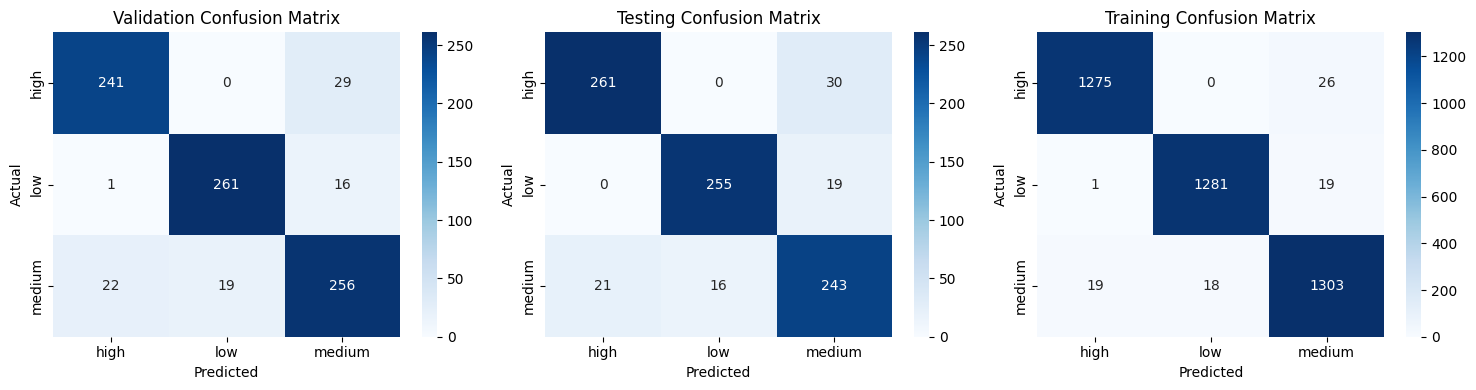

In [75]:
# Step 9: Plot confusion matrices
print("\nStep 9: Plotting confusion matrices...")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
class_names = label_encoder.classes_

datasets = [
    (y_val_encoded, val_pred, "Validation"),
    (y_test_encoded, test_pred, "Testing"),
    (y_train_encoded, train_pred, "Training")
]

for i, (y_true, y_pred, title) in enumerate(datasets):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=axes[i])
    axes[i].set_title(f'{title} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()



Step 10: Plotting training curves...


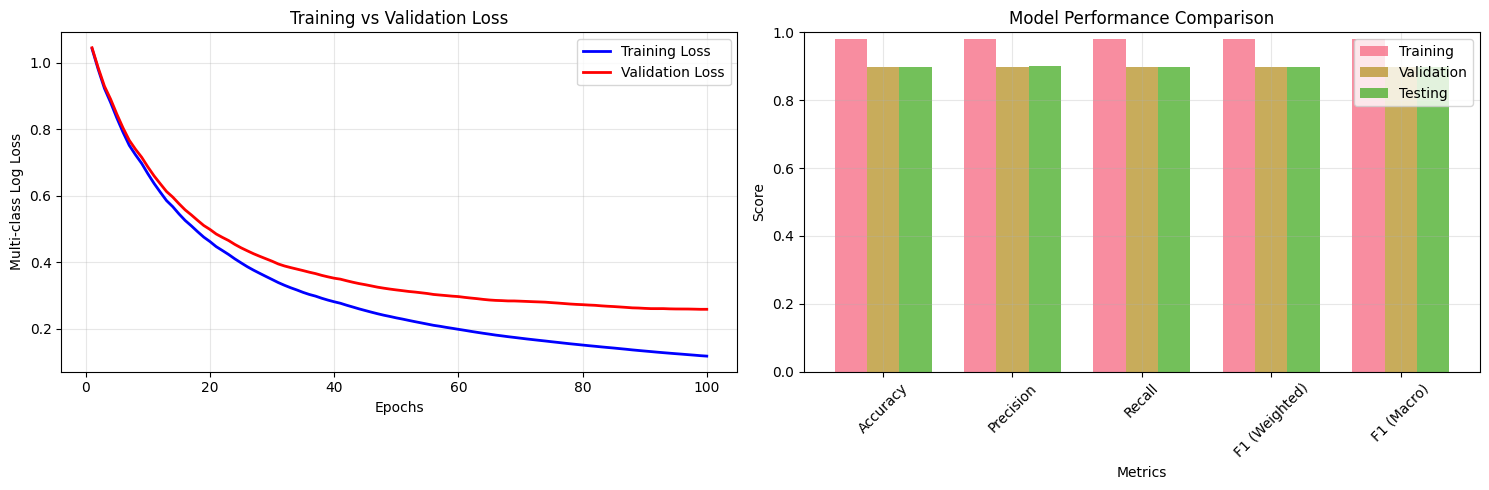

In [76]:
# Step 10: Plot training vs validation curves
print("\nStep 10: Plotting training curves...")

# Extract training history
train_loss = evals_result['train']['multi_logloss']
val_loss = evals_result['validation']['multi_logloss']

# Calculate accuracy for each epoch (approximate from loss)
epochs = range(1, len(train_loss) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Loss curves
ax1.plot(epochs, train_loss, 'b-', label='Training Loss', linewidth=2)
ax1.plot(epochs, val_loss, 'r-', label='Validation Loss', linewidth=2)
ax1.set_title('Training vs Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Multi-class Log Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Metrics comparison
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 (Weighted)', 'F1 (Macro)']
train_values = [train_metrics['accuracy'], train_metrics['precision'],
                train_metrics['recall'], train_metrics['f1_weighted'], train_metrics['f1_macro']]
val_values = [val_metrics['accuracy'], val_metrics['precision'],
              val_metrics['recall'], val_metrics['f1_weighted'], val_metrics['f1_macro']]
test_values = [test_metrics['accuracy'], test_metrics['precision'],
               test_metrics['recall'], test_metrics['f1_weighted'], test_metrics['f1_macro']]

x = np.arange(len(metrics_names))
width = 0.25

ax2.bar(x - width, train_values, width, label='Training', alpha=0.8)
ax2.bar(x, val_values, width, label='Validation', alpha=0.8)
ax2.bar(x + width, test_values, width, label='Testing', alpha=0.8)

ax2.set_title('Model Performance Comparison')
ax2.set_xlabel('Metrics')
ax2.set_ylabel('Score')
ax2.set_xticks(x)
ax2.set_xticklabels(metrics_names, rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
ax2.set_ylim(0, 1)
plt.show()



Step 11: Feature Importance...

Top 10 Most Important Features:
                              feature    importance
0                        Area (Acres)  40228.744877
12                       Crop_Cabbage   2541.374136
14                        Crop_Garlic   1930.367501
15                       Crop_Laushak   1703.883472
1   Temperature at 2 Meters Range (C)   1567.417710
11                         Crop_Beans   1480.733618
3        soil_temperature_0_to_7cm(C)   1442.532466
9             relative_humidity_2m(%)   1241.139498
13                   Crop_Cauliflower   1200.342793
17                        Crop_Radish   1153.713387


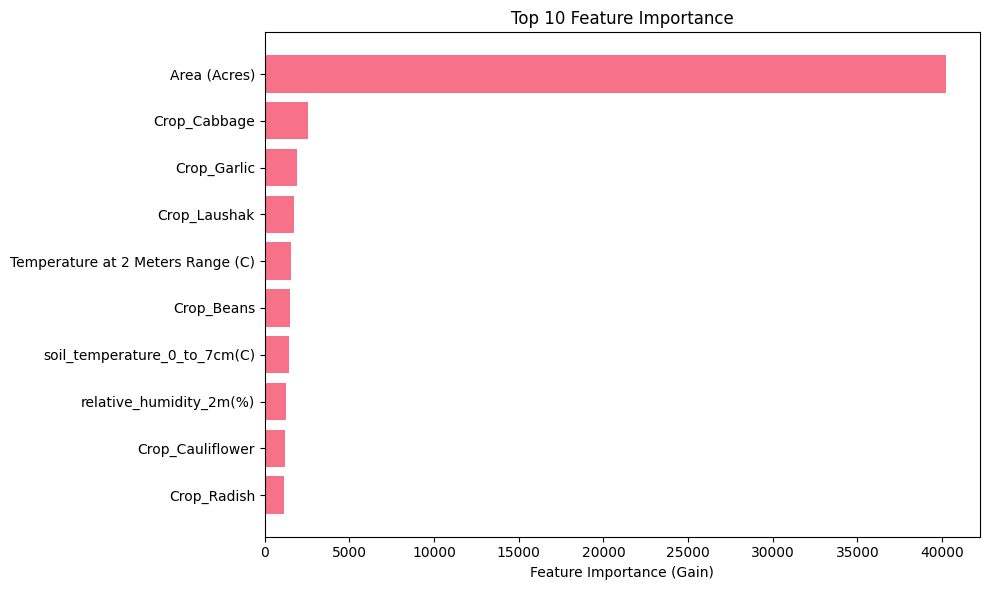

In [77]:
# Step 11: Feature importance
print("\nStep 11: Feature Importance...")

feature_importance = model.feature_importance(importance_type='gain')
feature_names = X_train.columns

# Create feature importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
top_features = importance_df.head(10)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance (Gain)')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [78]:
# Step 12: Detailed Classification Report
print("\nStep 12: Detailed Classification Reports...")

print("\nValidation Set Classification Report:")
print(classification_report(y_val_encoded, val_pred, target_names=class_names))

print("\nTest Set Classification Report:")
print(classification_report(y_test_encoded, test_pred, target_names=class_names))

# Summary
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"Model trained for {model.best_iteration} iterations")
print(f"Best validation loss: {min(val_loss):.4f}")

print(f"\nFinal Macro F1 Scores:")
print(f"Training: {train_metrics['f1_macro']:.4f}")
print(f"Validation: {val_metrics['f1_macro']:.4f}")
print(f"Testing: {test_metrics['f1_macro']:.4f}")

print(f"\nFinal Accuracy Scores:")
print(f"Training: {train_metrics['accuracy']:.4f}")
print(f"Validation: {val_metrics['accuracy']:.4f}")
print(f"Testing: {test_metrics['accuracy']:.4f}")

print("\nModel training and evaluation completed successfully!")


Step 12: Detailed Classification Reports...

Validation Set Classification Report:
              precision    recall  f1-score   support

        high       0.91      0.89      0.90       270
         low       0.93      0.94      0.94       278
      medium       0.85      0.86      0.86       297

    accuracy                           0.90       845
   macro avg       0.90      0.90      0.90       845
weighted avg       0.90      0.90      0.90       845


Test Set Classification Report:
              precision    recall  f1-score   support

        high       0.93      0.90      0.91       291
         low       0.94      0.93      0.94       274
      medium       0.83      0.87      0.85       280

    accuracy                           0.90       845
   macro avg       0.90      0.90      0.90       845
weighted avg       0.90      0.90      0.90       845


FINAL SUMMARY
Model trained for 99 iterations
Best validation loss: 0.2578

Final Macro F1 Scores:
Training: 0.9791
Vali